# Experimentation

In [1]:
%matplotlib inline
import random
import math
from collections import OrderedDict
import pickle

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

import soli_start
from reviews_soli import ReviewsSolicitation
from data_model import Feature
import uncertainty
import visualizer as viz

---
## Bliu dataset

This dataset include Amazon reviews of 14 products. Reviews are annotated manually with aspects and its polarities.

2017-06-08 14:36:17,897-DEBUG - 8 products with at least 4 aspects, each aspect has at least 10 ratings


------------------------output/2goals_3metrics_bliu_l10_p200_q2_5.pickle------------------------



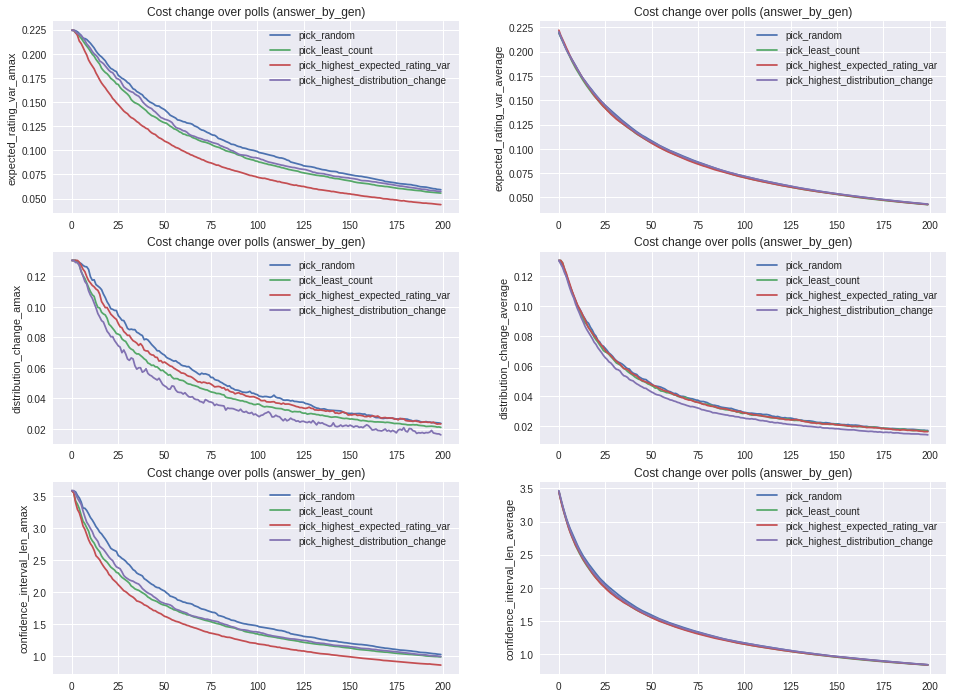

------------------------output/2goals_3metrics_bliu_l10_p200_q2_5.pickle------------------------



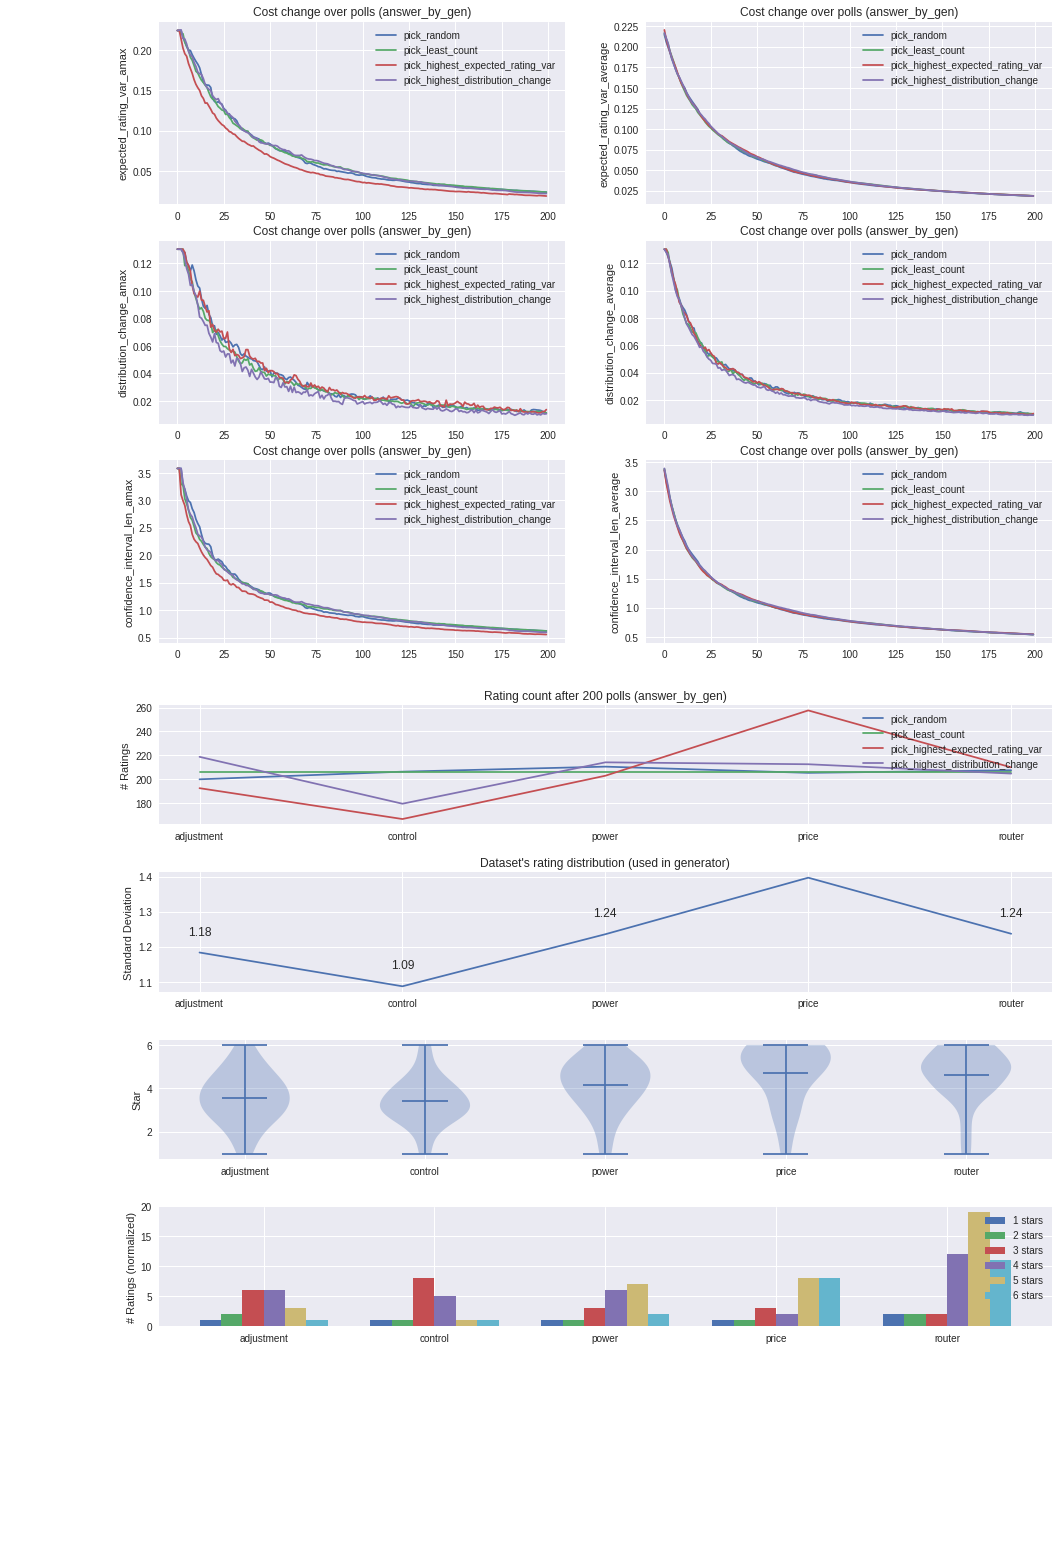

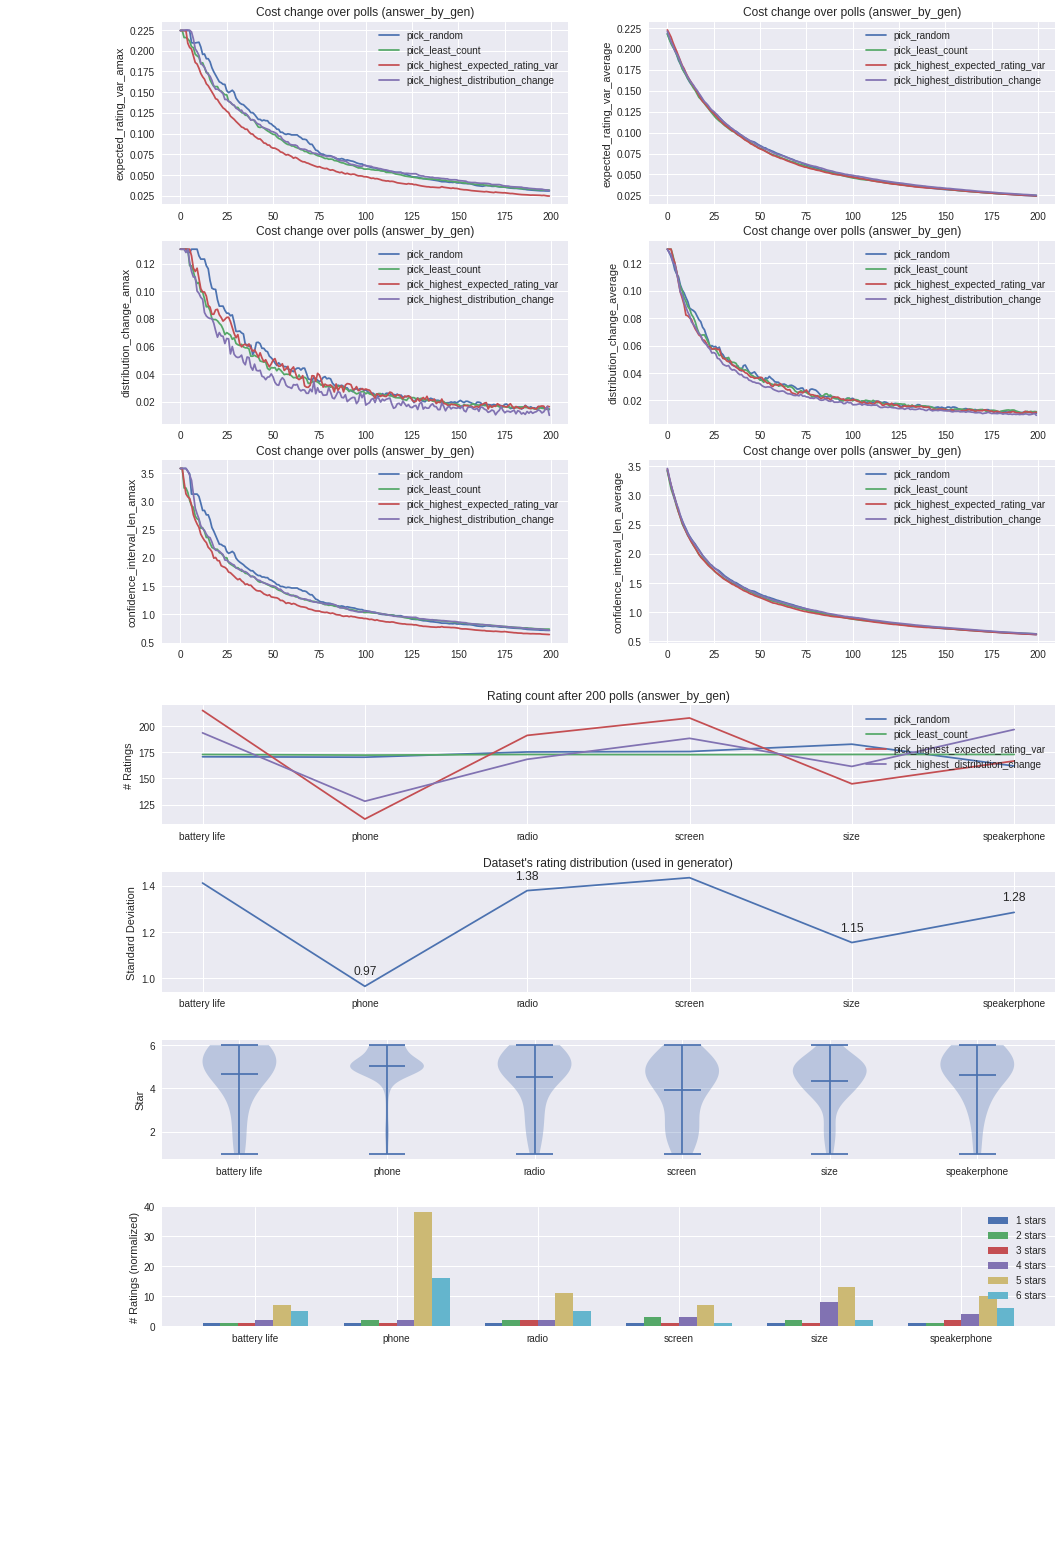

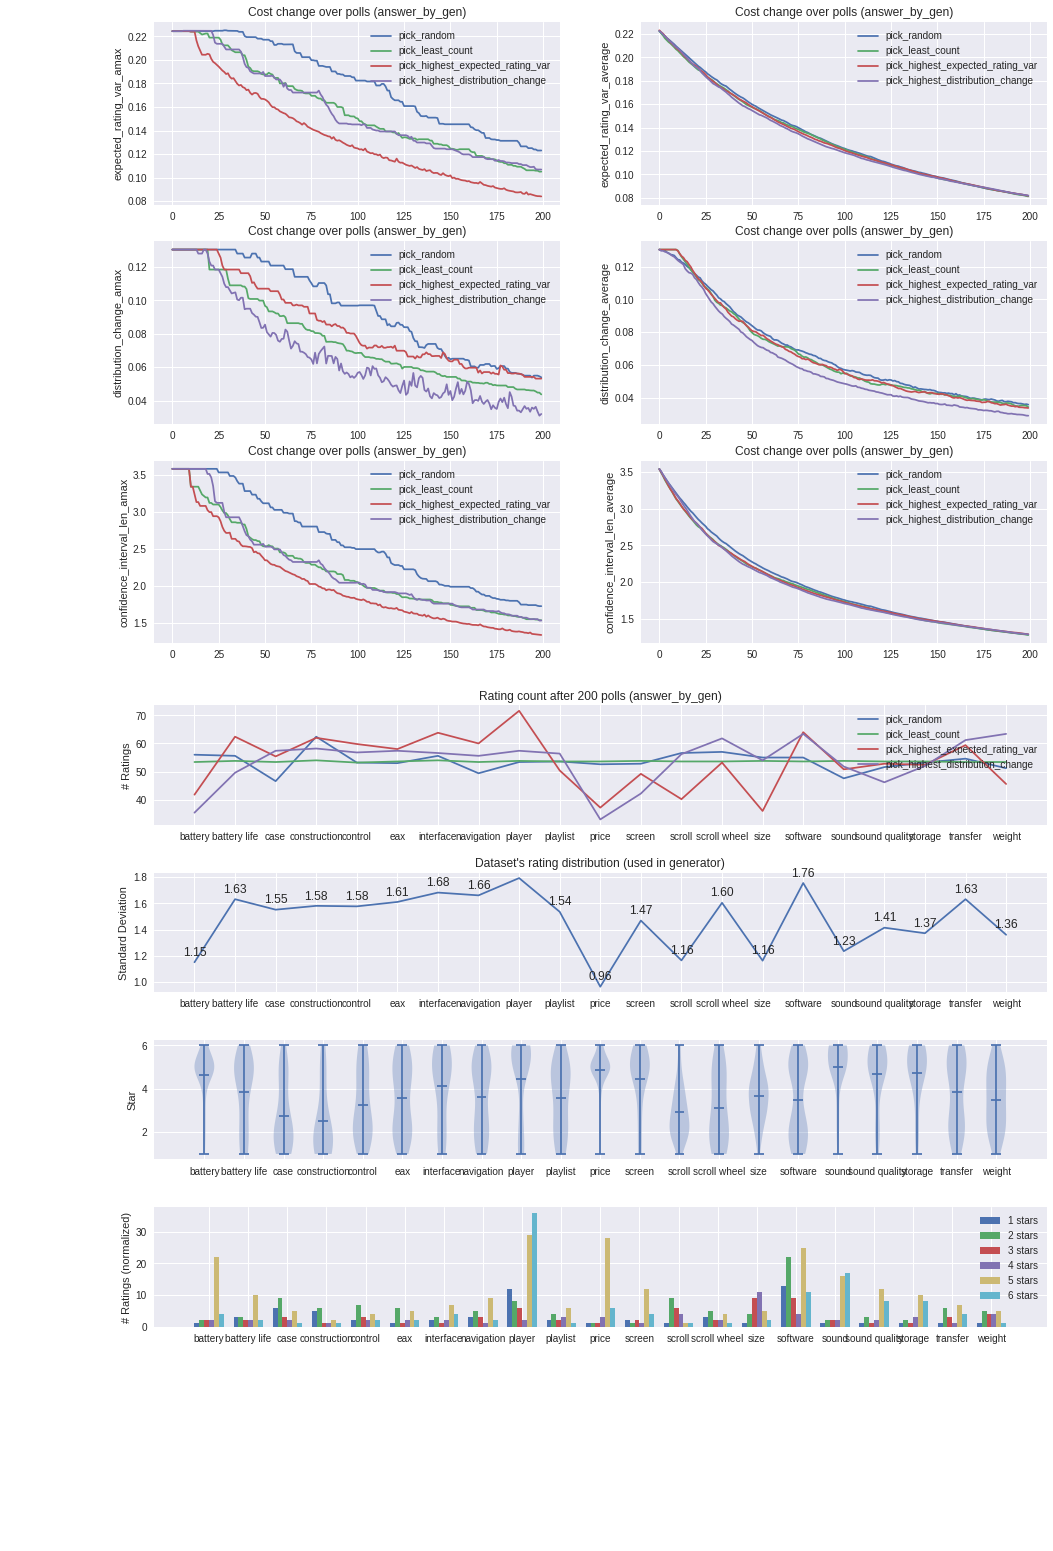

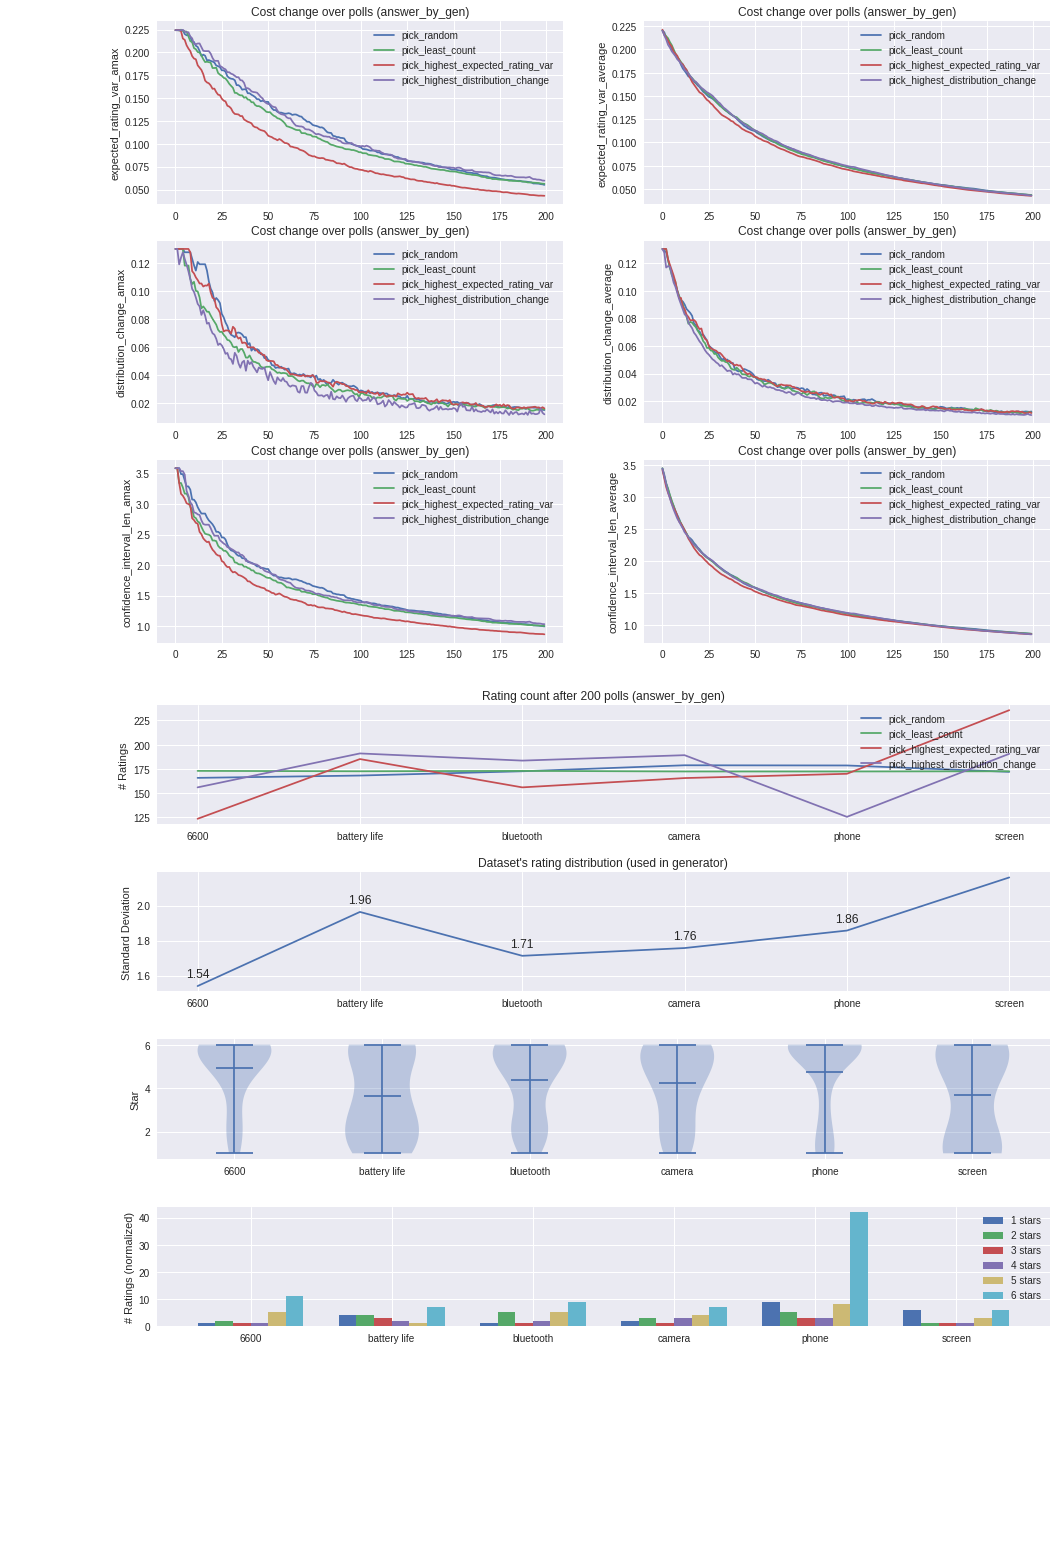

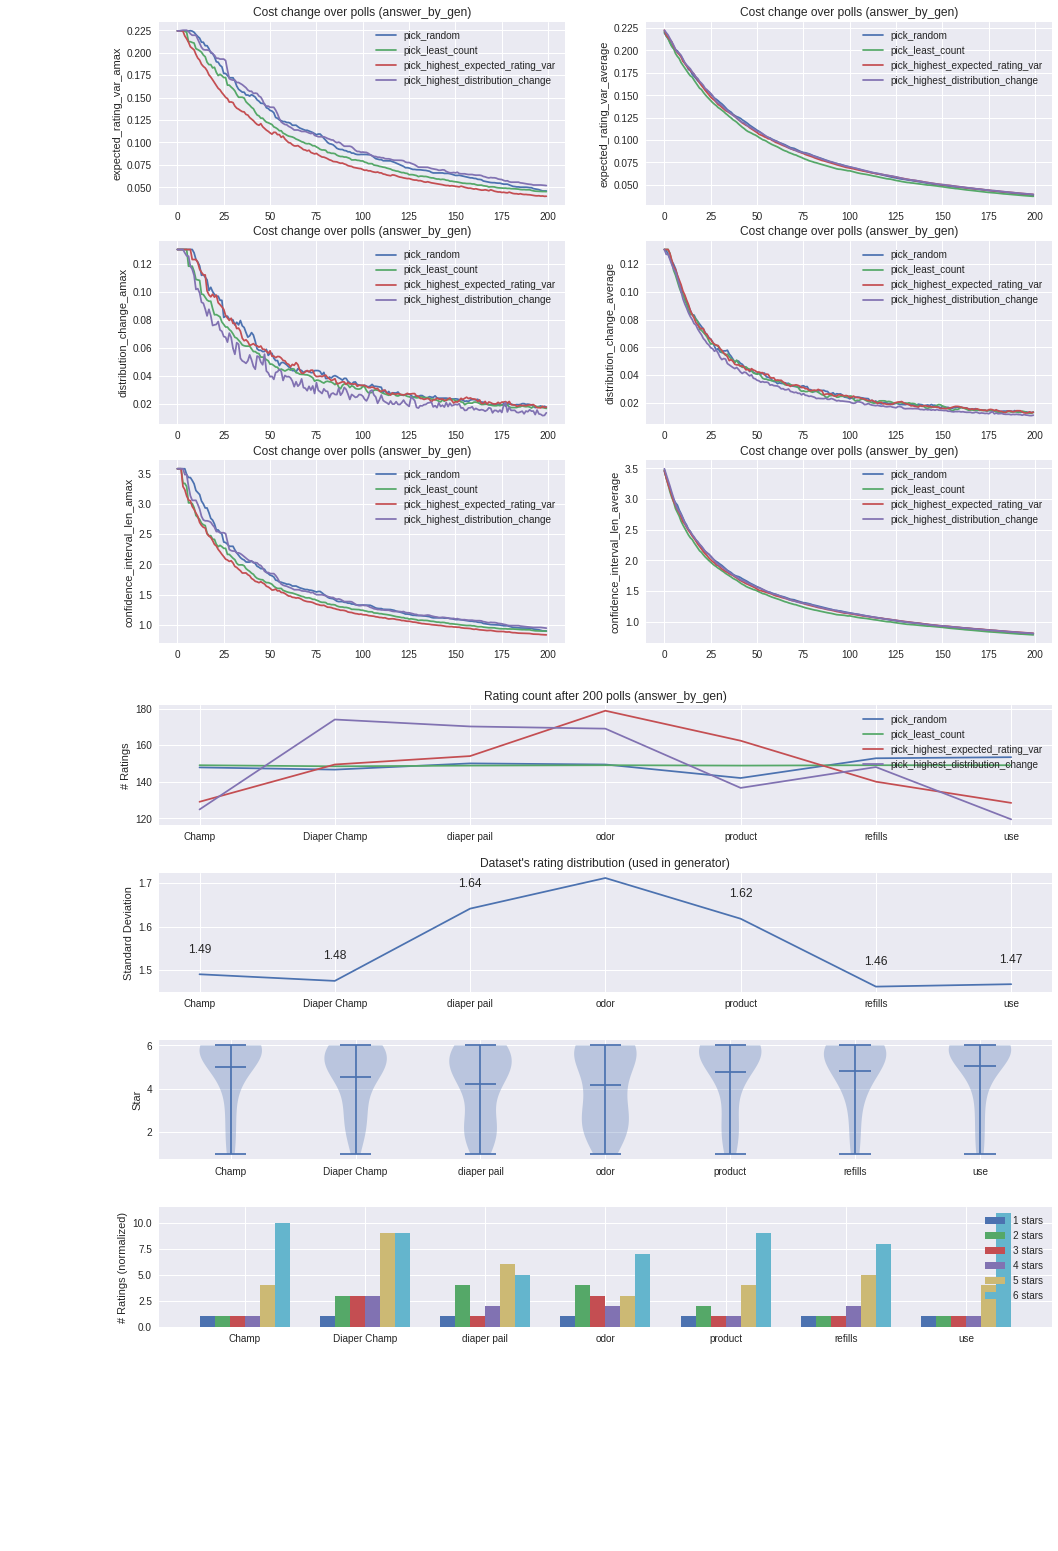

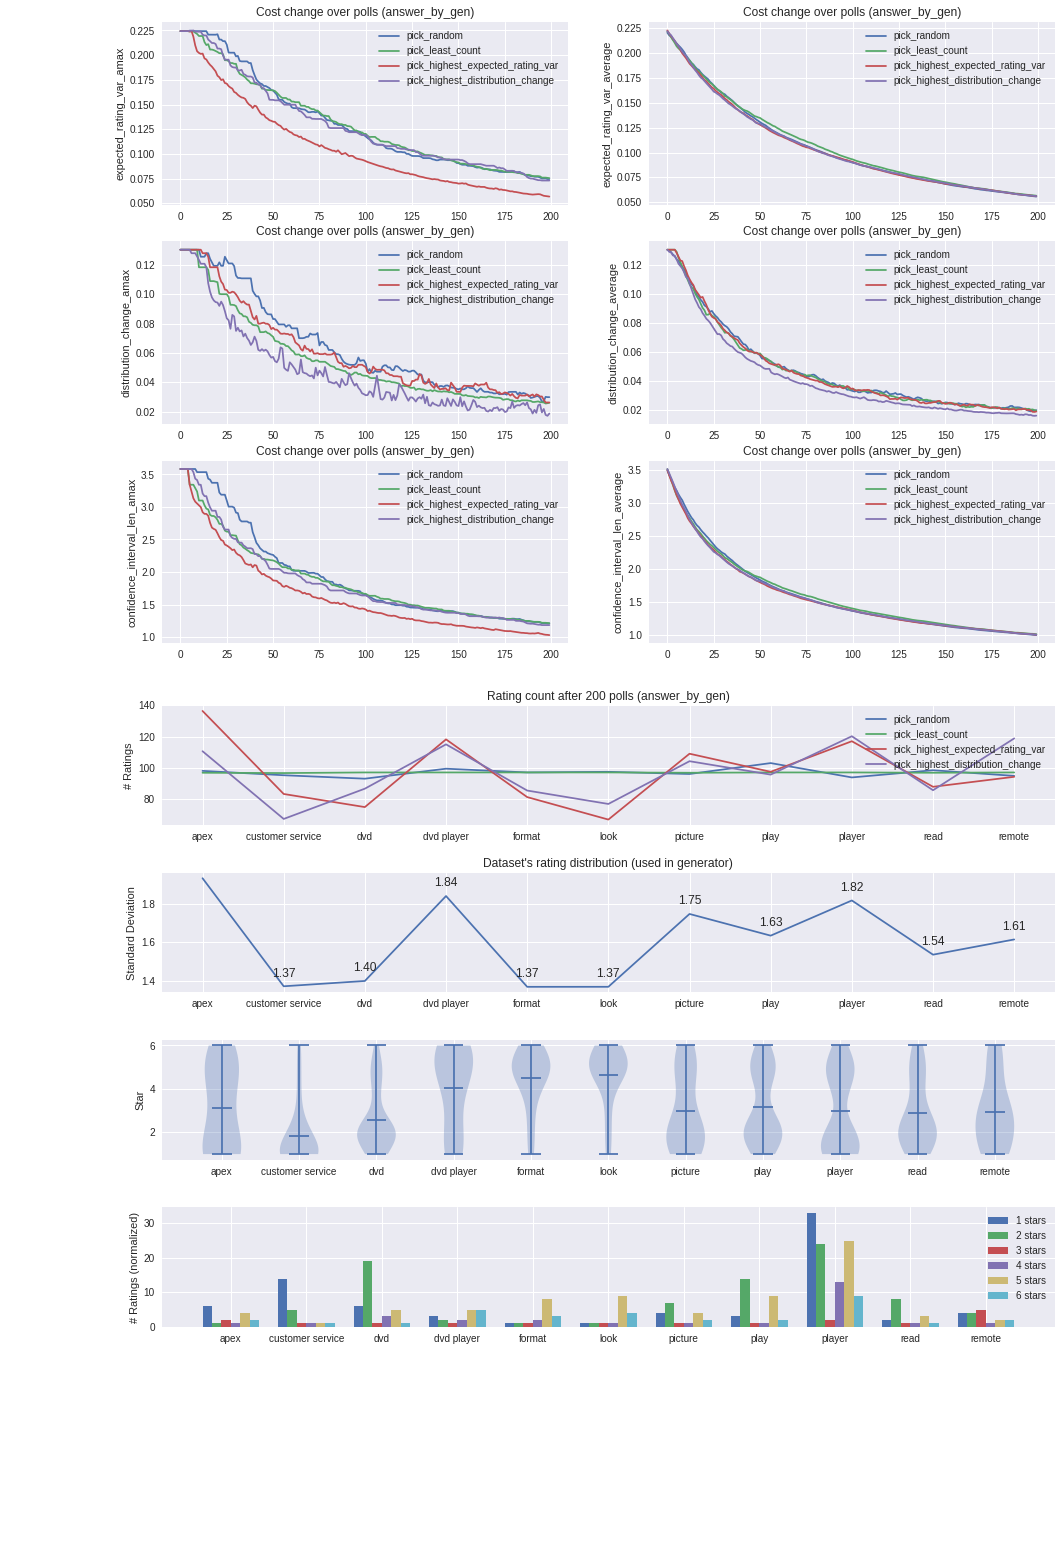

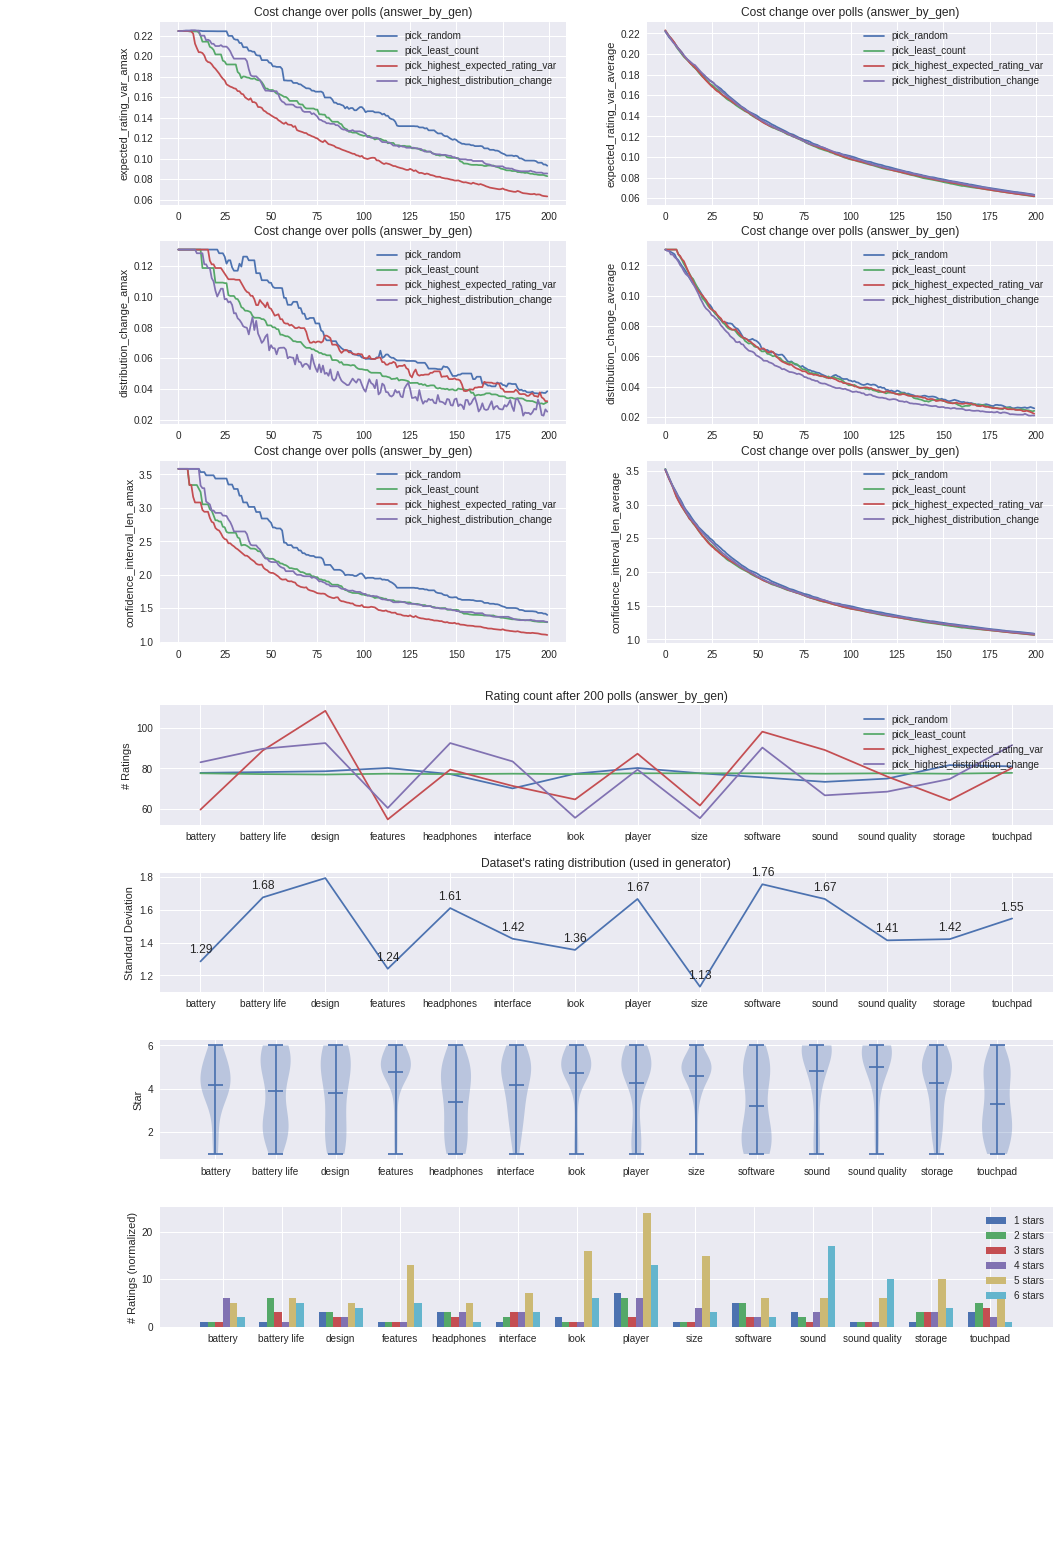

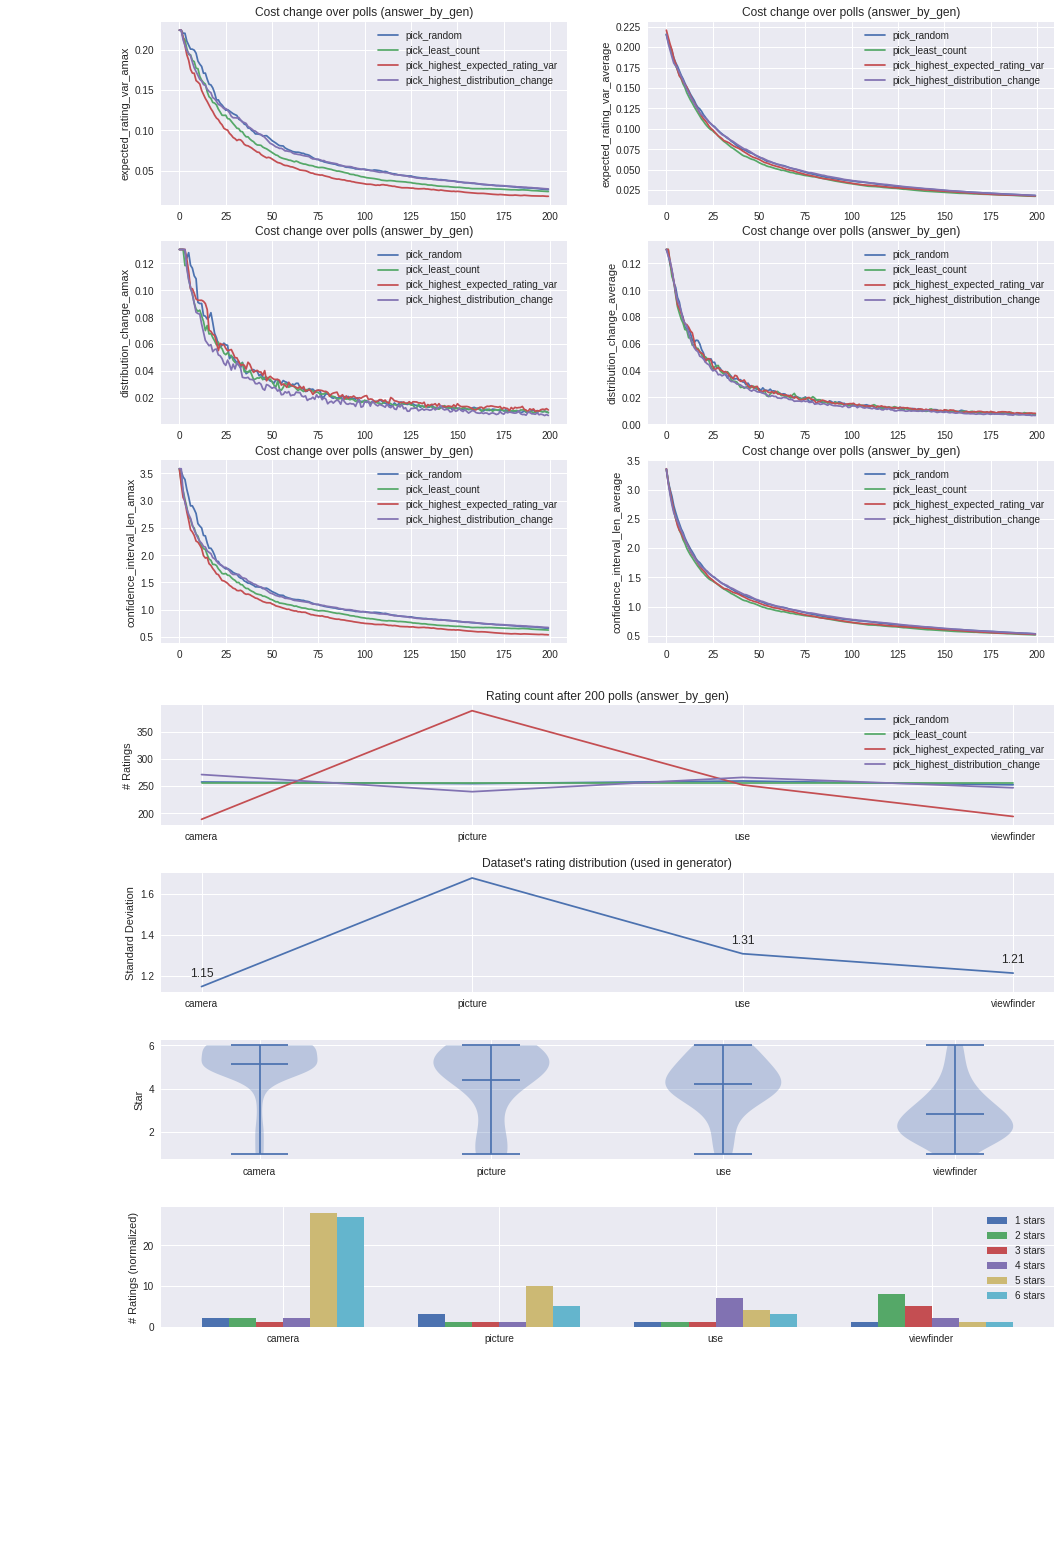

In [2]:
import bliu

bliu_pdf = PdfPages('plots/2goals_3metrics_bliu_p200_5_2.pdf')
bliu_result_paths = ['output/2goals_3metrics_bliu_l10_p200_q2_5.pickle']
path_to_product_stats = OrderedDict()
poll = 200

_, product_to_aspect_stars = bliu.BliuReview.preprocess_dataset(
    "anno-datasets/bliu-datasets")

for path in bliu_result_paths:
    with open(path, 'rb') as f:
        product_to_config_stats = pickle.load(f)
        path_to_product_stats[path] = product_to_config_stats

for path, product_to_stats in path_to_product_stats.items():
    print('------------------------{}------------------------\n'.format(path))
    soliconfig_to_stats_average = soli_start.summary_product_to_config_stats(
        product_to_stats, plotted_poll_end=poll, ignore_rating=True)
    fig = viz.plot_sim_stats(soliconfig_to_stats_average, poll=poll, plot_rating=False)
    fig.suptitle('Average over all products', fontsize=15, fontweight='bold')
    bliu_pdf.savefig(fig)
    
for path, product_to_stats in path_to_product_stats.items():
    print('------------------------{}------------------------\n'.format(path))
    for product, goal_to_stats in product_to_stats.items():
        fig = viz.plot_sim_stats(goal_to_stats, poll=poll,
                                 product=product,
                                 aspect_to_star_counts=product_to_aspect_stars[product])                                         
        fig.suptitle(product, fontsize=15, fontweight='bold')
        bliu_pdf.savefig(fig)

bliu_pdf.close()

---
## Edmunds dataset

All products (cars) have the same set of features/aspects.

Dataset of 5 stars, with 501 products and 53440 reviews
average of feature_rating_count/product = 77.766

Statistics of #reviews/product: min=1, max=1294, average=106.667, std=148.622, median=52.0


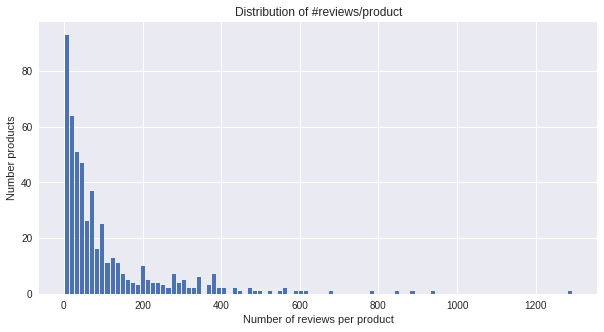

In [3]:
file_path = 'datasets/edmunds_reviews.csv'
dataset_profile = soli_start.probe_dataset(file_path)
print(dataset_profile)

# Distribution of #reviews/product
temp = dataset_profile.per_product_review_counts
print('Statistics of #reviews/product: min={min}, max={max}'
      ', average={average:.3f}, std={std:.3f}, median={median}' \
      .format(min=np.amin(temp), max=np.amax(temp),
              average=np.average(temp), std=np.std(temp), median=np.median(temp)))

fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(dataset_profile.per_product_review_counts, bins=100, rwidth=0.8)
ax.set_xlabel('Number of reviews per product')
ax.set_ylabel('Number products')
ax.set_title('Distribution of #reviews/product')
plt.show()

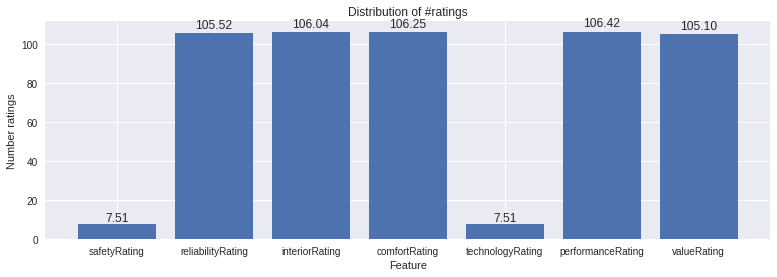

In [4]:
# Distribution of #feature_rating/product
fig, ax = plt.subplots(figsize=(13, 4))
features = list(dataset_profile.feature_to_review_count_average.keys())
num_ratings = list(dataset_profile.feature_to_review_count_average.values())
x_pos = np.arange(len(features))
rects = ax.bar(x_pos, num_ratings)

ax.set_xlabel('Feature')
ax.set_ylabel('Number ratings')
ax.set_title('Distribution of #ratings')
ax.set_xticks(x_pos)
ax.set_xticklabels(features)

for rect, num_rating in zip(rects, num_ratings):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.01*height,
            '{:.2f}'.format(num_rating), ha='center', va='bottom')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [5]:
edmunds_pdf = PdfPages('plots/edmunds_l950_p300.pdf')
#sim_result_paths = ['output/edmunds_l300_p300_q2.pickle', 'output/edmunds_l300_p300_q2_dup.pickle']
sim_result_paths = ['output/edmunds_l950_p300_q2.pickle', 'output/edmunds_l950_p300_q2_dup.pickle']
path_to_goal_stats = OrderedDict()
plotted_poll_end=290
#from IPython.core.debugger import Tracer; Tracer()()
for sim_result_path in sim_result_paths:
    with open(sim_result_path, 'rb') as f:
        product_to_config_stats = pickle.load(f)
   
    goal_to_stats_average = soli_start.summary_product_to_config_stats(
        product_to_config_stats, plotted_poll_end=plotted_poll_end)
    path_to_goal_stats[sim_result_path] = goal_to_stats_average

for path, goal_to_stats_average in path_to_goal_stats.items():
    print('------------------------{}------------------------\n'.format(path))
    fig = viz.plot_pick_answer_goals(goal_to_stats_average,
                                     poll_max=plotted_poll_end)
    edmunds_pdf.savefig(fig)
    
    print('------------------------Rating distribution------------------------\n')
    fig = viz.plot_ratings(goal_to_stats_average,
                           polls=[plotted_poll_end])
    edmunds_pdf.savefig(fig)
edmunds_pdf.close()

AttributeError: 'UncertaintyMetric' object has no attribute 'aggregate'